# mlp

> Implementation of mlp model using Pytorch

In [2]:
#| default_exp makemore.mlp

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from minion.makemore.bigram import stoi, itos

In [5]:
%matplotlib inline

## Motivations 

- Classical bigram model based on count is okay for bigram -2 characters
- However as we increase context windows, it quickly become out of hand
    - P(1 char|Given 1 prev char) -> 27 rows in Prob-table
    - P(1 char|Given 2 prev char) -> 27*27 = 729 rows in Prob-table
    - P(1 char|Given 3 prev char) -> 27 * 27 * 27 = 19683 ~ 20K rows in Prob-table or 20K possibilities of context

- Solution : Yoshua Bengio - Neural probabilistic language model
    - Word level language model (17K words, feature vector=30 - embedding--> Every word is embedded into 30 dimensional space). With 17K words, this space is very crowded - lot of points for 30 dimensional space
    - We will randomly initialize feature vectors per word
    - Then tune embeddings of the word using back propogation. During the course of training we can imagine that the words will be moving around in this space.
    - Intuition - words with very similar meanings or are synonyms of each other may end up in very similar part of this space. Words that mean very different things may go somewhere else in the space.

    Modelling approach
    - MLP to predict the next word given the previous word
    - To train the network weights - maximization of log likelihood.
    - 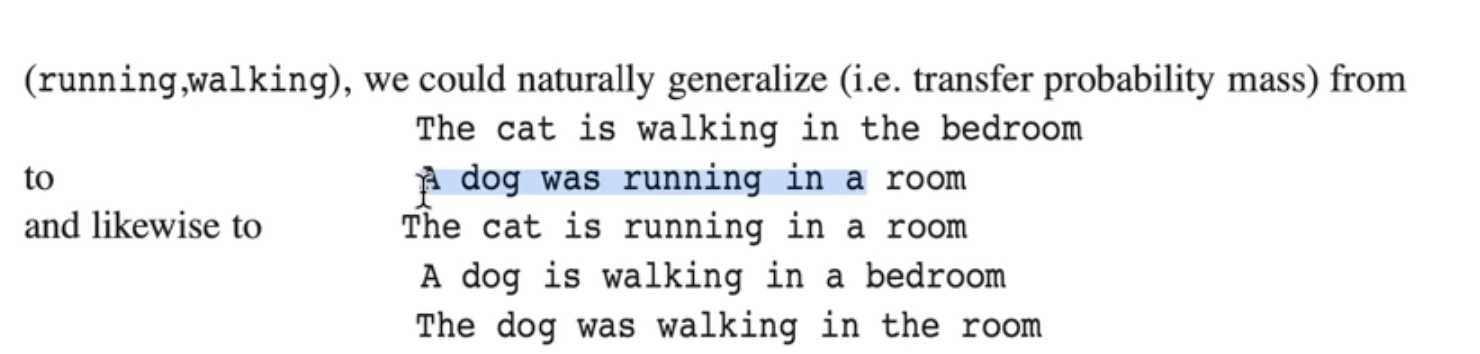
    - A and The in similar space
    - "A dog was running in a room" - never encountered in training set --> u are out of distribution
    - Probabilistic approach allows u to get around it --> May have seem similar sentences in training , "A" and "The" may seem to be frequently interchangable and therefore, may occupy similar space ["Cats" and "Dogs" are animal and they cooccur in very similar context]
    - Embedding helps in overcoming limitations and transfer knowledge through that way which helps in generalizing better
    - 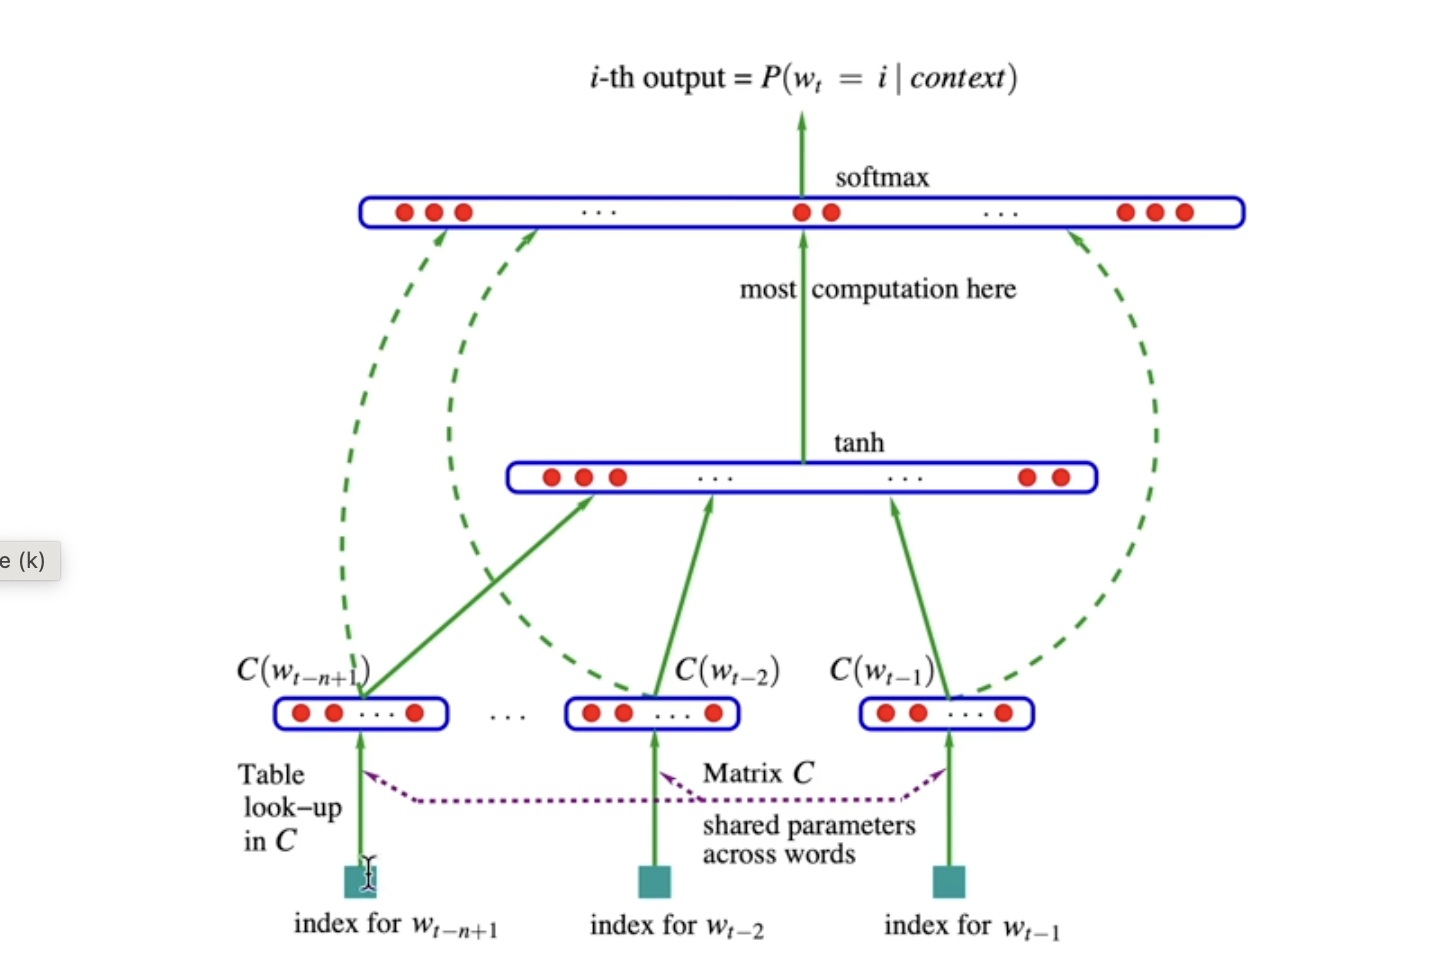
      - Matrix C is shared across the parameters/ words
      - Size of hidden layer is hyperparameter - this can be as large or as small. We will vary sizes and evalate how they work.
      - Output layer is with the softmax layer. --> 17K neurons- 17K logits -> softmax fully connected to all parameter in hidden layersoutput parameters
      - Parameters 
        - Weights and biases of output layer
        - Weights and biases of hidden layer
        - Look up table C [ How is this lookup table implemented??]


## Read the dataset

In [6]:
words = open("../data/names.txt", 'r').read().split(); words[:5]
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [7]:
s2i = stoi(words, start_str=".", end_str=".")
i2s = itos(s2i)
display(s2i)
display(i2s)

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [8]:
#| exports
def build_XY(words, s2i, block_size, str_term=".", verbose=False):
    X, Y = [], []
    for w in words:
        context = [s2i[str_term]]*block_size  # We need numerical embedding for each character 0 is for "."
        for ch in w + str_term:
            if verbose: 
                i2s = itos(s2i)
                print("".join([i2s[i] for i in context]),"-->", ch)
            X.append(context)
            Y.append(s2i[ch])
            context = context[1:] + [s2i[ch]]
    return torch.tensor(X), torch.tensor(Y)

In [9]:
X, Y = build_XY(words[:2], s2i, block_size=5, verbose=True)
X, Y

..... --> e
....e --> m
...em --> m
..emm --> a
.emma --> .
..... --> o
....o --> l
...ol --> i
..oli --> v
.oliv --> i
olivi --> a
livia --> .


(tensor([[ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  5],
         [ 0,  0,  0,  5, 13],
         [ 0,  0,  5, 13, 13],
         [ 0,  5, 13, 13,  1],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 15],
         [ 0,  0,  0, 15, 12],
         [ 0,  0, 15, 12,  9],
         [ 0, 15, 12,  9, 22],
         [15, 12,  9, 22,  9],
         [12,  9, 22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [10]:
X, Y = build_XY(words[:2], s2i, block_size=3, verbose=True)
X, Y

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [11]:
X, Y = build_XY(words, s2i, block_size=3)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [12]:
X, Y = build_XY(words[:5], s2i, block_size=3, verbose=True)
X.shape, X.dtype, Y.shape, Y.dtype

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Implementing Neural Network Step by Step

### Building embedding lookup table C

- 27 character and we need to embed them in lower dimensional space. 
- In paper they crammed 17K words in lower dimensional space (30)
- 27 characters with 2 dimensional space

In [13]:
C = torch.randn((len(s2i),2), generator=torch.Generator().manual_seed(2147483647)); C.shape

torch.Size([27, 2])

In [14]:
C[5]

tensor([-0.4713,  0.7868])

In [15]:
a = F.one_hot(torch.tensor(5), num_classes=len(s2i)) 

a.float()@C

tensor([-0.4713,  0.7868])

- If we take one_hot vector and multiply by `C`
- Embedding of integer can be thought of as 
  - Indexing integer in a look up table `C`
  - Also we can think of this piece as first layer of NN- No activation-Weight matrix in C. Simply a lookup

Now looking up a value for a character in C is simply looking up an index.

In [16]:
C[5]

tensor([-0.4713,  0.7868])

We can also do one-hot encoding of our charactar array and then provide one - hot vector and multiply by C which will pluck / lookup right weight for corresponding character

In [17]:
c5 = F.one_hot(torch.tensor(5), num_classes=len(s2i)).float() # One hot vector for 5th character + put input as tensor of float not int or tensor[int]
c5@C


tensor([-0.4713,  0.7868])

Above implies we can think of embedding in 2 ways

- Integer indexing into a look up table `C`
- Or First layer of bigger neural network
    - This embedding layer have neuron that have no non-linearity/ activation - linear 
    - And their weight matrix is `C`
    - We are just encoding the character to one-hot and feeding into NN and first layers basically embeds them
    - We index them because it's much much faster

### Sidenote on Pytorch indexing 

#### Index on int

In [18]:
C[5]

tensor([-0.4713,  0.7868])

#### Index on list

In [19]:
C[[5,6,7]]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334]])

#### Index on tensors

In [20]:
C[torch.tensor([5,6,7])]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334]])

In [21]:
C[torch.tensor([5,6,7, 7])]

tensor([[-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.3729,  2.9334]])

#### Index with multidimensional tensor of integers

In [22]:
display(C[X].shape)
display(C[X][:5])
display(C[X][:5].shape)

torch.Size([32, 3, 2])

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        [[-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 2.4448, -0.6701]],

        [[ 2.4448, -0.6701],
         [ 2.4448, -0.6701],
         [-0.0274, -1.1008]]])

torch.Size([5, 3, 2])

### Implementing embedding lookup table

In [23]:
C[X]

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        [[-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 2.4448, -0.6701]],

        [[ 2.4448, -0.6701],
         [ 2.4448, -0.6701],
         [-0.0274, -1.1008]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-1.0725,  0.7276]],

        [[ 1.5674, -0.2373],
         [-1.0725,  0.7276],
         [-0.0707,  2.4968]],

        [[-1.0725,  0.7276],
         [-0.0707,  2.4968],
         [ 0.6772, -0.8404]],

        [[-0.0707,  2.4968],
         [ 0.6772, -0.8404],
         [-0.1158, -1.2078]],

        [[ 0.6772, -0.8404],
         [-0.1158, -1.2078],
         [ 0.6772, -0.8404]],

        [[-0.1158, -1

In [24]:
X.shape, C[X].shape

(torch.Size([32, 3]), torch.Size([32, 3, 2]))

We have a character input of 32 by 3 . For each of them we have gotten an embedding vector

In [25]:
display(X[13,2])
C[X][13, 2]

tensor(1)

tensor([-0.0274, -1.1008])

In [26]:
C[1]

tensor([-0.0274, -1.1008])

In [27]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

### Implementing the hidden layer + internals of torch.Tensor: storage, views

- We are going to stack 3 characters . So number of features for hidden layers are 6 (3*2)
- We can choose any number of neurons for hidden layer. Let's start by choosing 100 neurons
- Size of hidden layer (features, neurons)


In [28]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

What we want to do emb@W1+b1?

- Above won't work 
- emb size is 32*3*2
- W1 size is 6*100
- We somehow need to concatenate multiple embeddings into single tensor array


In [29]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969,

In [30]:
emb.shape

emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape # Not scalable with larger context

torch.Size([32, 6])

In [31]:
a = torch.unbind(emb, 1)
len(a); a

(tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-1.0725,  0.7276],
         [-0.0707,  2.4968],
         [ 0.6772, -0.8404],
         [-0.1158, -1.2078],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.0274, -1.1008],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 0.6772, -0.8404],
         [ 0.1476, -1.0006],
         [-0.0274, -1.1008],
         [ 0.2859, -0.0296],
         [-0.4713,  0.7868],
         [-0.0707,  2.4968],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 0.1476, -1.0006],
         [-1.0725,  0.7276],
         [ 0.0511,  1.3095],
         [ 1.5618, -1.6261]]),
 tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0

In [32]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [33]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [34]:
a.view(2, 9)
a.view(9,2)
a.view(3,3,2) # Extremely efficient 

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [35]:
a.storage()

/var/folders/df/3bwv425110q0kc25hg9gcjw1nrdglc/T/ipykernel_18787/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

:::callout-important

- In pytorch, tensor is always stored as a 1 dimensional vector ( represented in computer memory)
- When calling view - internals of tensors - storage offsets, strides and shapes are being manipulated
- Calling view is extremely efficient . No memory is being changed 
- Concatenation is much less efficient - New memory is being created when u use concatenation(Whole new tensor with a whole new storage). No way of concatenating the tensor by manipulating the view attribute
- Tensor shape is just a logical view of physical memory 
    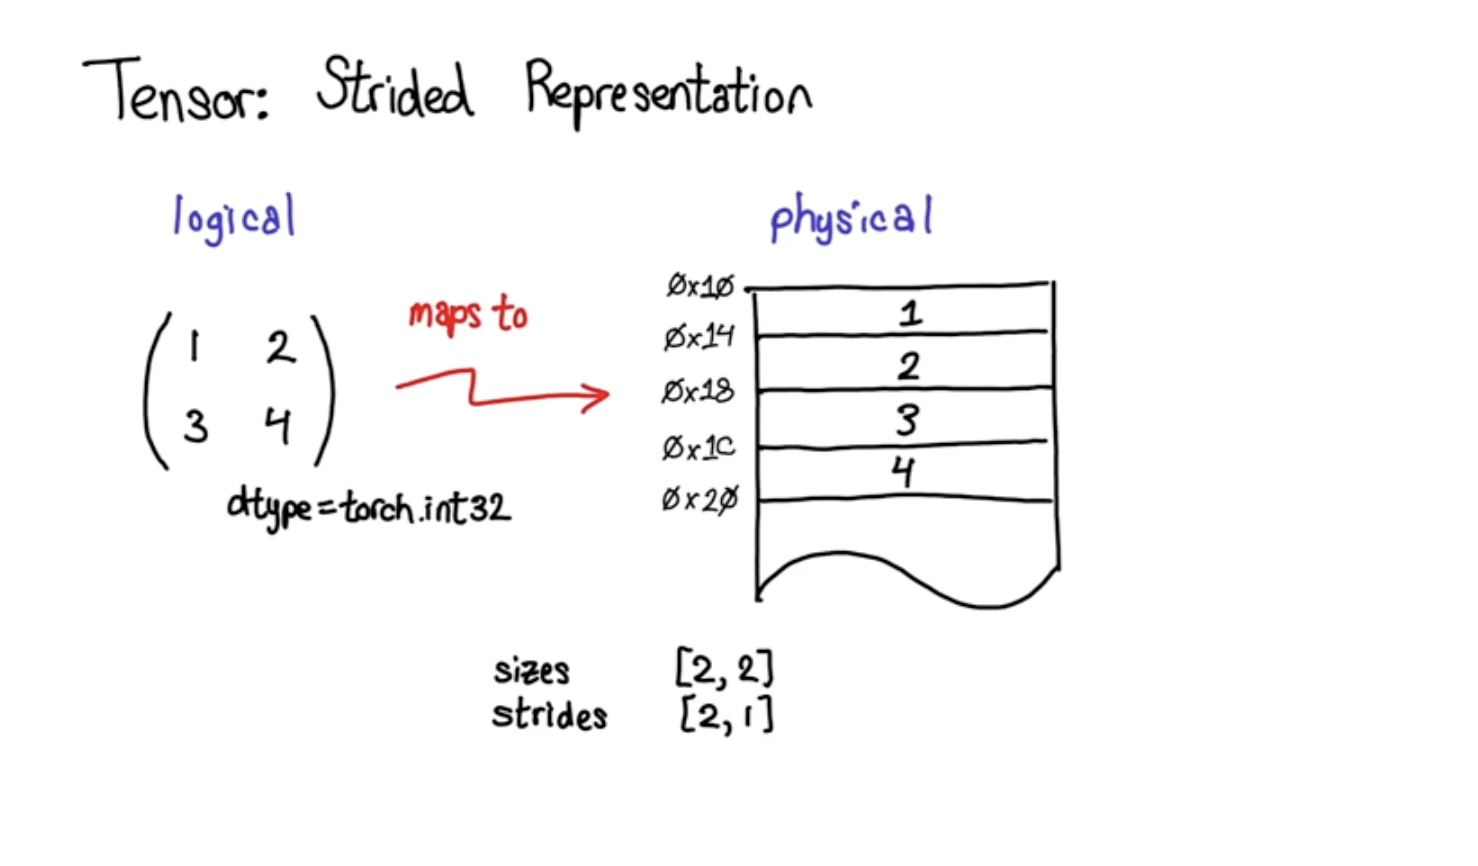
- More on Pytorch internals is [here](http://blog.ezyang.com/2019/05/pytorch-internals/)


:::

In [36]:
emb.shape

emb[1]

tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.4713,  0.7868]])

In [37]:
emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])[1]

tensor([ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868])

In [38]:
emb.view(-1, 6)[1]

tensor([ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868])

In [39]:
emb.view(emb.shape[0], -1)[1]

tensor([ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868])

In [40]:
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2])@W1 + b1)
h

tensor([[-0.6740, -0.8138,  0.9996,  ...,  0.8002,  0.9752, -0.3210],
        [-0.9337, -0.9946, -0.6062,  ..., -0.3759, -0.2326, -0.2902],
        [ 0.8539, -0.9943,  1.0000,  ..., -0.9920,  0.9974,  0.2649],
        ...,
        [ 0.9979,  0.9918,  1.0000,  ...,  0.8957,  0.8814,  0.5611],
        [-0.8554,  1.0000,  0.9328,  ...,  0.9999,  0.9759, -0.8245],
        [-0.9996,  0.6655,  0.9921,  ...,  0.9280,  0.8530, -0.9992]])

### Final layer


In [41]:

W2 = torch.randn((100, len(s2i)))
b2 = torch.randn(len(s2i))

In [42]:
logits = h@W2+b2; logits.shape

torch.Size([32, 27])

In [43]:
counts = logits.exp()

In [44]:
prob = counts / counts.sum(1, keepdims=True); prob.shape

torch.Size([32, 27])

In [45]:
prob.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

## Refactoring 

### Model Class

In [74]:
#| exports
class Model(object):
    def __init__(self, s2i, blck_sz=3, emb_sz=2, hidden_units=100, g=torch.Generator().manual_seed(2147483647)) -> None:
        self.C = torch.randn((len(s2i),emb_sz), generator=g, requires_grad=True)
        self.W1 = torch.randn((blck_sz*emb_sz, hidden_units), generator=g, requires_grad=True)
        self.b1 = torch.randn(hidden_units, generator=g, requires_grad=True)
        self.W2 = torch.randn((hidden_units, len(s2i)), generator=g, requires_grad=True)
        self.b2 = torch.randn(len(s2i), generator=g, requires_grad=True)
        self.blck_sz = blck_sz
        self.emb_sz = emb_sz
        self.hidden_units = hidden_units

    def __call__(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2])@self.W1 + self.b1)
        logits = h@self.W2 + self.b2
        return logits
    
    def parameters(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    def zero_grad(self):
        for p in self.parameters(): 
            # print(p.shape, p.data, p.grad)
            p.grad = None
    

In [75]:
F.cross_entropy??

Signature:
F.cross_entropy(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> torch.Tensor
Source:   
def cross_entropy(
    input: Tensor,
    target: Tensor,
    weight: Optional[Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = "mean",
    label_smoothing: float = 0.0,
) -> Tensor:
    r"""This criterion computes the cross entropy loss between input logits and target.

    See :class:`~torch.nn.CrossEntropyLoss` for details.

    Args:
        input (Tensor) : Predicted unnormalized logits;
            see Shape section below for supported shapes.
        target (Tensor) : Ground truth class indices or class probabilities;
            see Shape section below for supported shape

### Model loss

In [76]:
#| exports
def nll(input,  #Takes logits
        target  #Takes y
        ): 
    counts = logits.exp()
    probs = counts/ counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(len(Y)), Y].log().mean()
    return loss



### Forward Pass and Update

In [77]:
X, Y = build_XY(words[:5], s2i, block_size=3); X.shape, Y.shape
lr = 0.01
model = Model(s2i)

# Forward Pass
logits = model(X); logits.shape 
# loss = nll(logits, Y)
loss = F.cross_entropy(logits, Y)
loss2 = nll(logits, Y)

# Backward Pass
model.zero_grad()
loss.backward(); loss, loss2

# # Update
# for p in model.parameters():
#     p.data -= lr*p.grad

# model.parameters()[0].grad

# model.parameters()[1].grad
# len(model.parameters())

for p in model.parameters():
    p.data -=lr*p.grad




### Minibatch Construct

In [78]:
# torch.randint()
display(X.shape)

torch.randint(low=0, high=10, size=(3,))

torch.Size([32, 3])

tensor([2, 2, 2])

In [79]:
batch_size = 32
ix = torch.randint(low=0, high=X.shape[0], size=(batch_size,))

X[ix].shape

torch.Size([32, 3])

In [80]:
#| exports
def plot_embeddings(model, s2i):
    i2s = itos(s2i)
    plt.figure(figsize=(8,8))
    plt.scatter(model.C[:,0].data, model.C[:,1].data, s=200)
    for i in range(model.C.shape[0]):
        # plt.text()
        plt.text(model.C[i,0].item(), model.C[i,1].item(), i2s[i], ha='center', va='center', color='white')
    plt.grid()

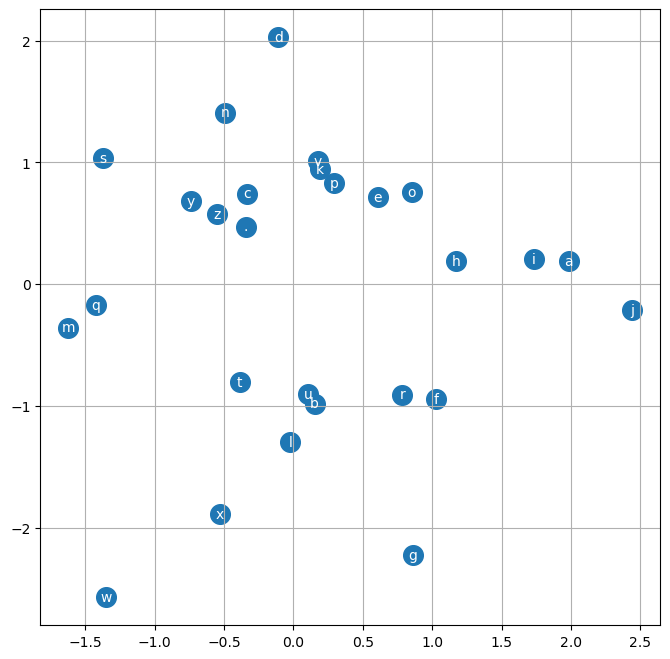

In [81]:
model = Model(s2i)
plot_embeddings(model, s2i)

### Training Function

In [82]:
#| exports
def train(model, X, Y, lr=0.1, epochs=1000, verbose=False, batch_sz=None, loss_fn=F.cross_entropy, tracker = None):
    for i in range(epochs):
    
        #minibatch construct
        inputs = X
        target = Y
        if batch_sz:
            ix = torch.randint(low=0, high=X.shape[0], size=(batch_sz,))
            inputs = X[ix]
            target = Y[ix]
        
        # Forward Pass
        logits = model(inputs); logits.shape 
        # loss = nll(logits, Y)
        loss = loss_fn(logits, target)
        # loss2 = nll(logits, Y)

        # Backward Pass
        model.zero_grad()
        loss.backward(); 
        if i%100 == 0 and verbose: print(i, loss)
        if i == epochs-1: print(i, loss)


        ## Update / Gradient 
        for p in model.parameters():
            p.data -=lr*p.grad

        if tracker is not None:
            tracker.get('lr', []).append(lr)
            tracker.get('loss', []).append(loss.item())
            tracker.get('batch_sz', []).append(batch_sz)
            tracker.get('block_sz', []).append(X.shape[1])
            tracker.get('emb_sz', []).append(model.C.shape[1])
            tracker.get('hidden_units', []).append(model.b1.shape[0])
    return model


In [83]:
X.shape[1]

3

In [84]:
X, Y = build_XY(words, s2i, block_size=3); X.shape, Y.shape
model = Model(s2i)

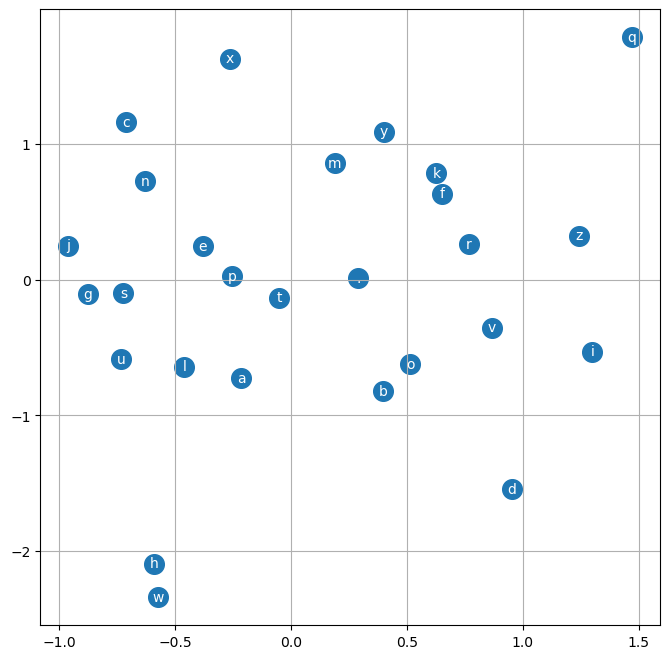

In [85]:
plot_embeddings(model, s2i)

In [86]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }

In [87]:
model = train(model, X, Y,  epochs=400, verbose=True, tracker=tracker, batch_sz=None)

0 tensor(16.2380, grad_fn=<NllLossBackward0>)
100 tensor(3.0585, grad_fn=<NllLossBackward0>)
200 tensor(2.8185, grad_fn=<NllLossBackward0>)
300 tensor(2.7211, grad_fn=<NllLossBackward0>)
399 tensor(2.6639, grad_fn=<NllLossBackward0>)


In [88]:
tracker is not None

True

In [89]:
tracker.keys()

dict_keys(['lr', 'batch_sz', 'loss', 'block_sz', 'emb_sz', 'hidden_units'])

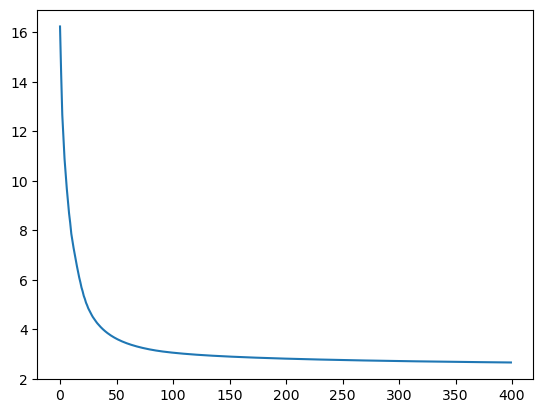

In [90]:
plt.plot(tracker['loss'])

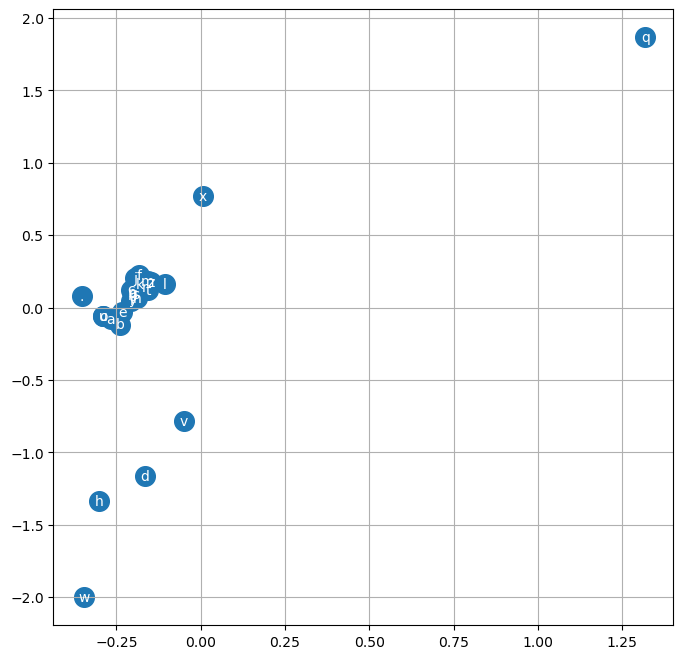

In [91]:
plot_embeddings(model, s2i)

### Training with minibatch

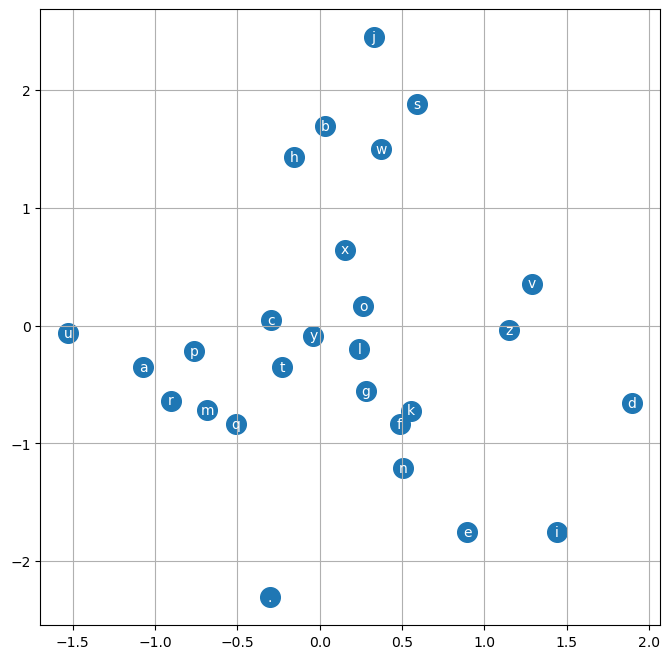

In [92]:
X, Y = build_XY(words, s2i, block_size=3); X.shape, Y.shape
model = Model(s2i)
plot_embeddings(model, s2i)

In [93]:
tracker = {'lr':[], 'batch_sz':[], 'loss':[], 'block_sz':[], 'emb_sz':[], 'hidden_units':[] }


In [94]:
model = train(model, X, Y,  epochs=2000, verbose=True, tracker=tracker, batch_sz=32); model

0 tensor(18.0536, grad_fn=<NllLossBackward0>)
100 tensor(3.7672, grad_fn=<NllLossBackward0>)
200 tensor(3.3227, grad_fn=<NllLossBackward0>)
300 tensor(3.2613, grad_fn=<NllLossBackward0>)
400 tensor(3.3499, grad_fn=<NllLossBackward0>)
500 tensor(3.0279, grad_fn=<NllLossBackward0>)
600 tensor(2.8018, grad_fn=<NllLossBackward0>)
700 tensor(2.5104, grad_fn=<NllLossBackward0>)
800 tensor(2.8692, grad_fn=<NllLossBackward0>)
900 tensor(2.6770, grad_fn=<NllLossBackward0>)
1000 tensor(3.3610, grad_fn=<NllLossBackward0>)
1100 tensor(2.5722, grad_fn=<NllLossBackward0>)
1200 tensor(2.7489, grad_fn=<NllLossBackward0>)
1300 tensor(2.9044, grad_fn=<NllLossBackward0>)
1400 tensor(2.5464, grad_fn=<NllLossBackward0>)
1500 tensor(2.4261, grad_fn=<NllLossBackward0>)
1600 tensor(2.3919, grad_fn=<NllLossBackward0>)
1700 tensor(2.8807, grad_fn=<NllLossBackward0>)
1800 tensor(2.5584, grad_fn=<NllLossBackward0>)
1900 tensor(2.7698, grad_fn=<NllLossBackward0>)
1999 tensor(2.8636, grad_fn=<NllLossBackward0>)


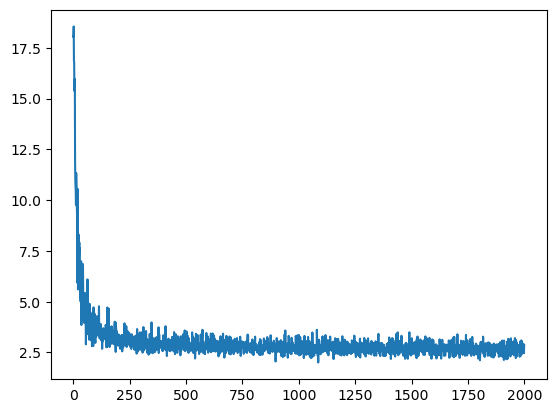

In [95]:
plt.plot(tracker['loss'])

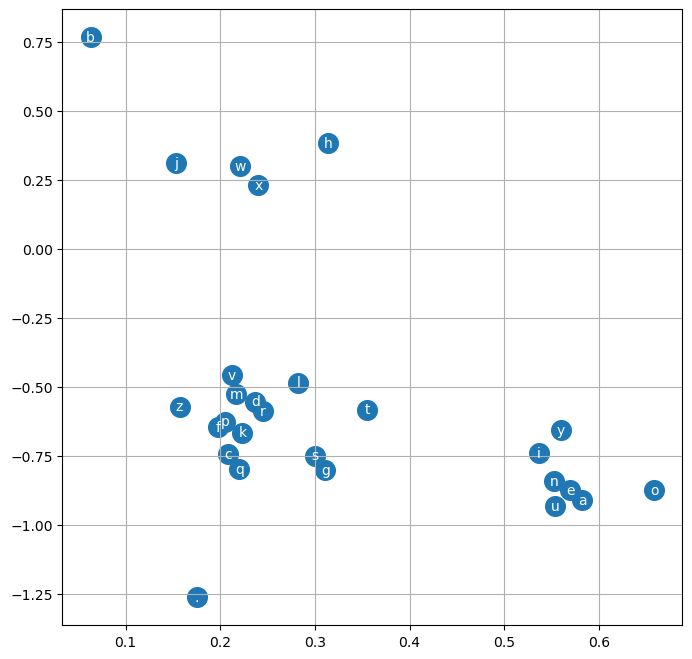

In [68]:
plot_embeddings(model, s2i)

### Implementing Word Generator

In [228]:
# X[ix]
ix = 0
# model.C[X[ix]]
X[ix]

# model(torch.tensor([0,0,0]))

emb = model.C[torch.tensor([0,0,0])]
# emb.shape[0], emb.shape[1], emb.shape[2]
emb.shape

torch.Size([3, 2])

In [229]:
X[ix]
X.shape

torch.Size([228146, 3])

In [281]:
ix = 0
g=torch.Generator().manual_seed(2147483647)

n_samples = 20
gen_words = []

In [282]:
for i in range(n_samples):
    ix = 0
    gen_word = ""
    inp = [ix]*model.blck_sz
    
    while True:
        logits = model(torch.tensor([inp]))
        counts = logits.exp() # equivalent N
        probs = counts/ counts.sum(1, keepdims=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        
        inp.pop(0)
        inp.append(ix)
        if ix == 0: break
        else: gen_word +=i2s[ix]
    gen_words.append(gen_word)
    
# probs
ix


0

In [291]:
inp, words

([1, 9, 0],
 ['cexir',
  'lealaurarleritah',
  'erllirittainrlgaak',
  'kanaa',
  'raliyleeltthrii',
  'tas',
  'idlieeltao',
  'kerteda',
  'kaler',
  'mesede',
  'eakavgyryrltlse',
  'huniveavtarlasu',
  'rsdr',
  'baneilhanel',
  'iranlir',
  'fdinee',
  'zkr',
  'deru',
  'firet',
  'kai'])

In [292]:
#| exports
def gen_word_nn(model, i2s, n_samples=20, g=torch.Generator().manual_seed(2147483647)):
    gen_words = []
    for i in range(n_samples):
        ix = 0
        gen_word = ""
        inp = [ix]*model.blck_sz
        
        while True:
            logits = model(torch.tensor([inp]))
            counts = logits.exp() # equivalent N
            probs = counts/ counts.sum(1, keepdims=True)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            
            inp.pop(0)
            inp.append(ix)
            if ix == 0: break
            else: gen_word +=i2s[ix]
        gen_words.append(gen_word)
    return gen_words

In [296]:
gen_word_nn(model, i2s)

['taraalnee',
 'lhae',
 'keo',
 'seadasea',
 'krr',
 'arhon',
 'keita',
 'suynn',
 'miuilwan',
 'rahan',
 'jinderie',
 'kecieghanlhanee',
 'osi',
 'kdrnela',
 'trrta',
 'rmirrrleltanle',
 'rar',
 'sakcarlircagala',
 'calakielenvpllcirl',
 'uuh']

In [297]:
#| hide
import nbdev; nbdev.nbdev_export()